# Choosing a location for an oil well

You work for the mining company BigOilCompany. We need to decide where to drill a new well.

You have been provided with oil samples in three regions: in each 10,000 fields, where the quality of oil and the volume of its reserves were measured. Build a machine learning model that will help determine the region where mining will bring the greatest profit. Analyze the possible profits and risks with the *Bootstrap technique.*

Steps to select a location:

- They are looking for deposits in the selected region, the values of the parameters are determined for each;
- Build a model and estimate the volume of reserves;
- - Select the deposits with the highest value estimates. The number of deposits depends on the company's budget and the cost of developing one well;
- The profit is equal to the total profit of the selected fields.


<div class="paragraph">Oil samples were provided in three regions. The characteristics for each well in the region are already known. Build a model to determine the region where mining will bring the greatest profit. Analyze the possible profits and risks with the <em>Bootstrap technique.</em></div>

<h2>Data description</h2><div class="paragraph">The exploration data of the three regions are in the files: </div>
<ul>
    <li><code class="code-inline code-inline_theme_light">geo_data_0.csv</code>.</li>
    <li><code class="code-inline code-inline_theme_light">geo_data_1.csv</code>.</li>
    <li><code class="code-inline code-inline_theme_light">geo_data_2.csv</code>.</li>
    <li><em>id</em> — unique well ID;</li>
    <li><em>f0, f1, f2</em> — three features of wells (it doesn't matter what they mean, but they themselves are significant);</li>
    <li><em>product</em> — the volume of reserves in the well (thousand barrels).</li>
</ul>

<div class="paragraph"><strong>Task conditions:</strong></div>
<ul>
   <li>Only linear regression is suitable for training the model (the rest are insufficiently predictable).</li>
<li>During the exploration of the region, 500 points are explored, from which 200 best ones are selected for development using machine learning.</li><li>The budget for the development of wells in the region is 10 billion rubles.</li>
<li>At current prices, one barrel of raw materials brings 450 rubles of income. The income from each unit of the product is 450 thousand rubles, since the volume is indicated in thousands of barrels.</li>
<li>After assessing the risks, you need to leave only those regions in which the probability of losses is less than 2.5%. The region with the highest average profit is chosen among them.</li>
</ul>

## Loading and preparing data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
# import numpy as np
import seaborn as sns
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# from scipy.stats import t
from numpy.random import RandomState


rcParams['figure.figsize'] = (9, 6)

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None

plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

sns.set_style("whitegrid", {'figure.facecolor': '0.97'});
sns.set_palette("Set2");

<Figure size 648x432 with 0 Axes>

In [2]:
def evaluate_df(df):
    '''
    Function for simple analysing the dataset
    
    '''
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # число пропусков
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))

    display(df.describe(include='all').transpose())
    
    pd.plotting.scatter_matrix(df, figsize=(16,10), alpha=0.1, s=5);

def show_dependency(df):
    '''
    function to draw projections on xy, xz, yz planes
    '''
    figure = plt.figure(figsize=(9,18))
    ax = plt.subplot(3,1, 1)
    sns.scatterplot( x='f0', y='f1', data=df, hue='product'
                    , alpha=0.2
                    , edgecolor = 'none'
                    , s=5
                    , ax = ax
    );
    ax = plt.subplot(3,1, 2)
    sns.scatterplot( x='f0', y='f2', data=df, hue='product'
                    , alpha=0.2
                    , edgecolor = 'none'
                    , s=5
                    , ax = ax
    );
    ax = plt.subplot(3,1, 3)
    sns.scatterplot( x='f1', y='f2', data=df, hue='product'
                    , alpha=0.2
                    , edgecolor = 'none'
                    , s=5
                    , ax = ax
    );

In [3]:
df_0 = pd.read_csv('../../datasets/geo_data_0.csv', sep=',')
df_1 = pd.read_csv('../../datasets/geo_data_1.csv', sep=',')
df_2 = pd.read_csv('../../datasets/geo_data_2.csv', sep=',')

df_all = {'Region #0': df_0, 'Region #1': df_1, 'Region #2': df_2}


------SAMPLE--------


id     f0     f1     f2  product
78138  TIv00 -0.561  0.739  1.796  128.612
33793  9gMun  1.058  0.460 -2.408    0.133
96457  oibhp  1.053  0.358  0.754    1.600
42524  R3fAe  1.603 -0.099 -2.126   48.204
74255  BKnBM  1.921 -0.270  5.231  166.607


------DTYPES--------
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


------NaN & zero--------
        NA  filled zero %na
id       -  100000    -   -
f0       -  100000    -   -
f1       -  100000    -   -
f2       -  100000    -   -
product  -  100000    1   -


count unique    top freq   mean    std     min    25%    50%  \
id           100000  99990  fiKDv    2    NaN    NaN     NaN    NaN    NaN   
f0      100,000.000    NaN    NaN  NaN  0.500  0.872  -1.409 -0.073  0.502   
f1      100,000.000    NaN    NaN  NaN  0.250  0.504  -0.848 -0.201  0.250   
f2      100,000.000    NaN    NaN  NaN  2.503  3.248 -12.088  0.288  2.516   
product 100,000.000    NaN    NaN  NaN 92.500 44.289   0.000 56.498 91.850   

            75%     max  
id          NaN     NaN  
f0        1.074   2.362  
f1        0.701   1.344  
f2        4.715  16.004  
product 128.564 185.364

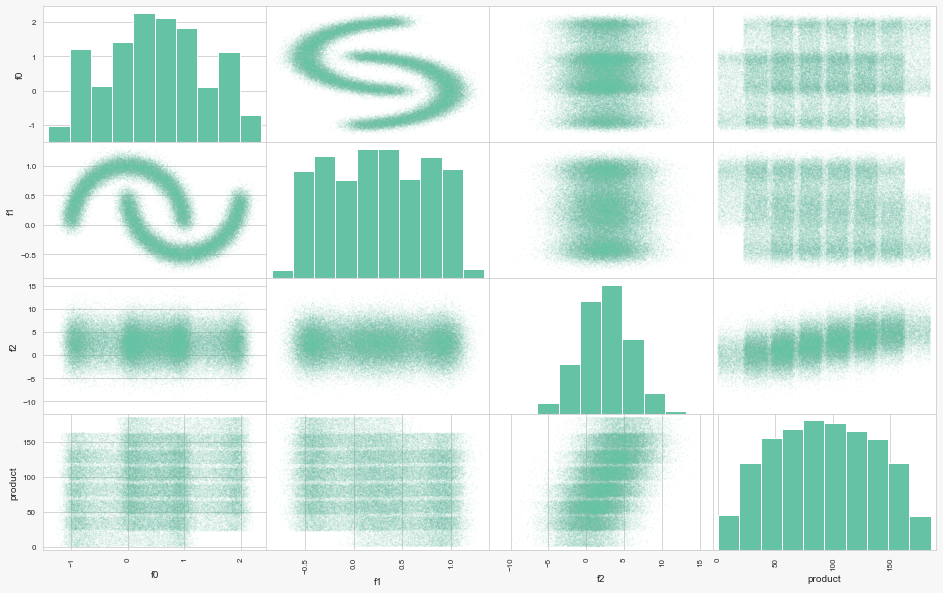

In [4]:
evaluate_df(df_0)

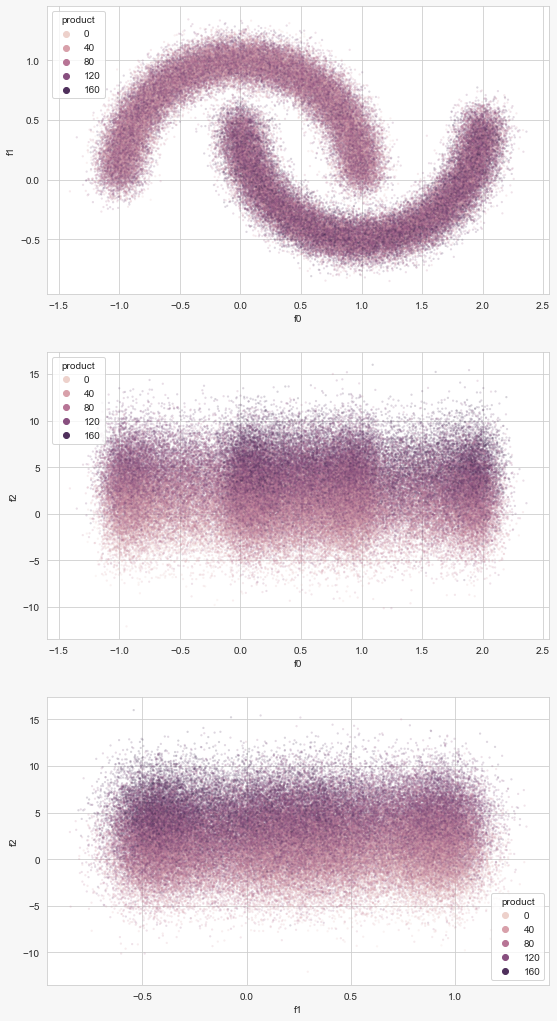

In [5]:
show_dependency(df_0)


------SAMPLE--------


id      f0     f1     f2  product
19781  2XSuf   6.927  3.469  1.992   53.907
13937  32g5U   9.660 -4.350  0.998   26.953
719    q11O6  -6.594 -8.102  3.002   84.039
6278   rEXSq -11.418 -5.268 -0.013    3.179
48220  IAU4j   6.499 -8.227  1.999   53.907


------DTYPES--------
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


------NaN & zero--------
        NA  filled  zero %na
id       -  100000     -   -
f0       -  100000     -   -
f1       -  100000     -   -
f2       -  100000     -   -
product  -  100000  8235   -


count unique    top freq   mean    std     min    25%    50%  \
id           100000  99996  wt4Uk    2    NaN    NaN     NaN    NaN    NaN   
f0      100,000.000    NaN    NaN  NaN  1.141  8.966 -31.610 -6.299  1.153   
f1      100,000.000    NaN    NaN  NaN -4.797  5.120 -26.359 -8.268 -4.813   
f2      100,000.000    NaN    NaN  NaN  2.495  1.704  -0.018  1.000  2.011   
product 100,000.000    NaN    NaN  NaN 68.825 45.944   0.000 26.953 57.086   

            75%     max  
id          NaN     NaN  
f0        8.621  29.422  
f1       -1.333  18.734  
f2        4.000   5.020  
product 107.813 137.945

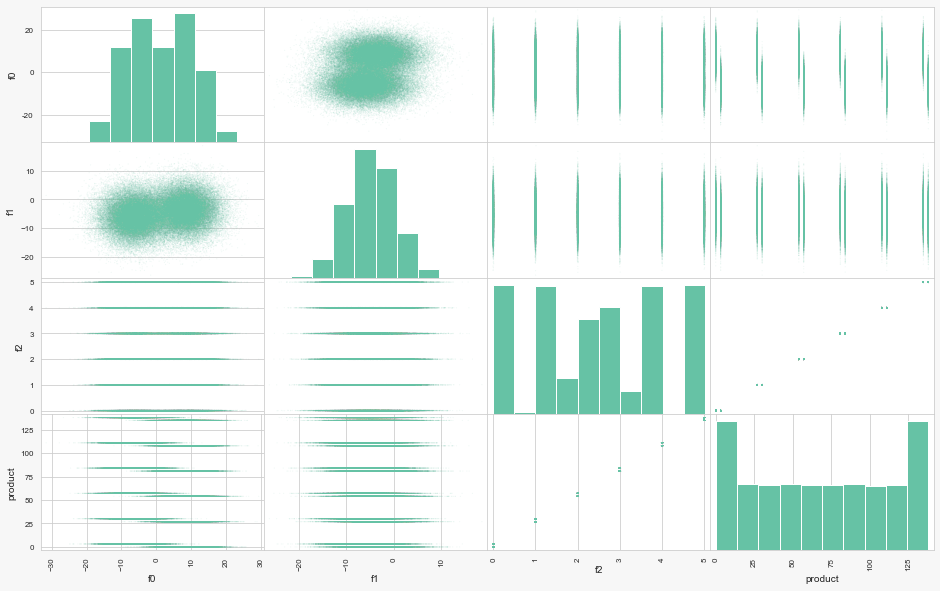

In [6]:
evaluate_df(df_1)

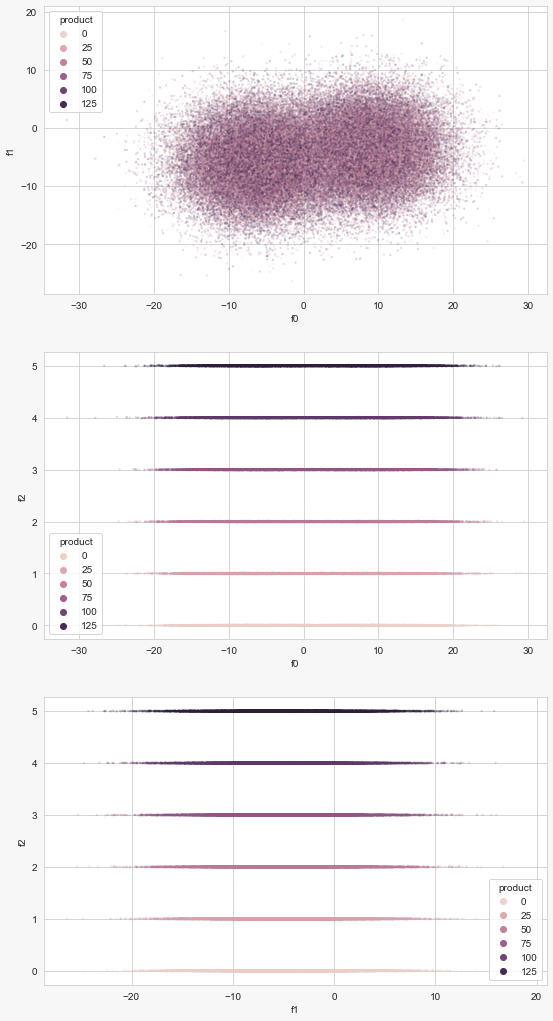

In [7]:
show_dependency(df_1)


------SAMPLE--------


id     f0     f1     f2  product
56046  ZOvNT  1.417  0.357  1.950   51.439
25258  gb8xL  1.770 -2.658  3.719   48.493
66363  41y5P  1.141  1.337  2.368  107.205
77085  klHKE  0.452  0.205  6.998  113.269
54961  lA5wJ -1.578  2.750 -4.579   51.908


------DTYPES--------
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


------NaN & zero--------
        NA  filled zero %na
id       -  100000    -   -
f0       -  100000    -   -
f1       -  100000    -   -
f2       -  100000    -   -
product  -  100000    1   -


count unique    top freq   mean    std     min    25%    50%  \
id           100000  99996  VF7Jo    2    NaN    NaN     NaN    NaN    NaN   
f0      100,000.000    NaN    NaN  NaN  0.002  1.732  -8.760 -1.162  0.009   
f1      100,000.000    NaN    NaN  NaN -0.002  1.730  -7.084 -1.175 -0.009   
f2      100,000.000    NaN    NaN  NaN  2.495  3.473 -11.970  0.130  2.484   
product 100,000.000    NaN    NaN  NaN 95.000 44.750   0.000 59.450 94.926   

            75%     max  
id          NaN     NaN  
f0        1.159   7.238  
f1        1.164   7.845  
f2        4.859  16.739  
product 130.595 190.030

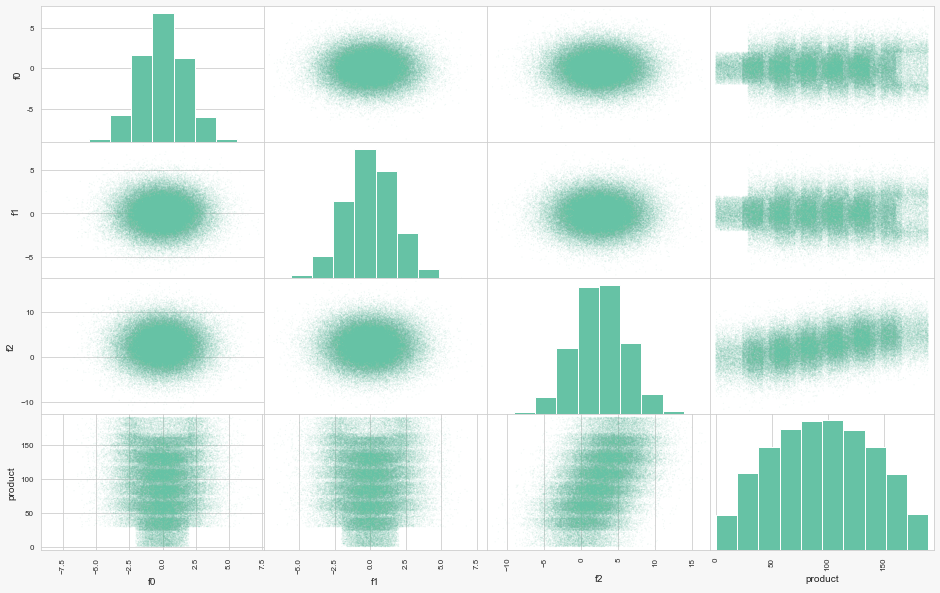

In [8]:
evaluate_df(df_2)

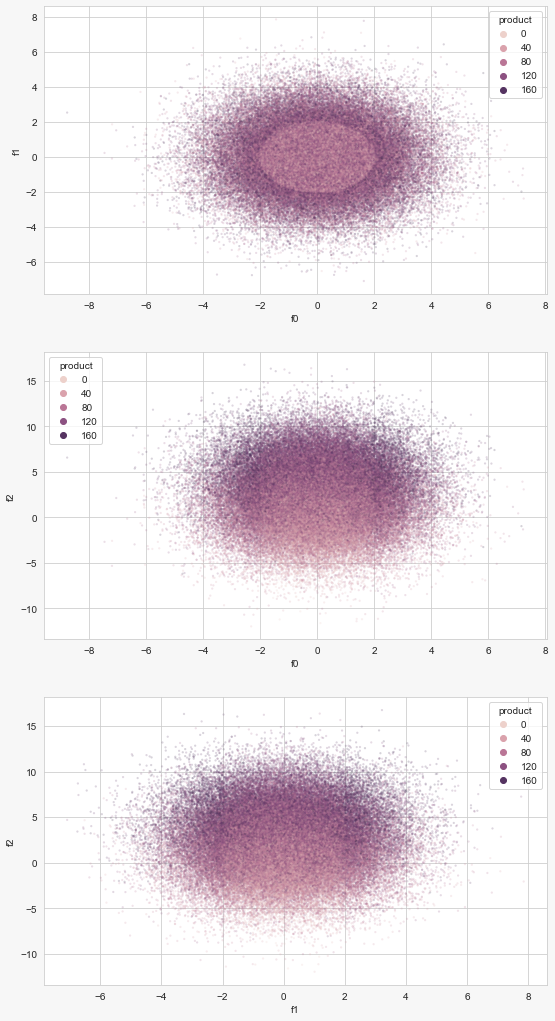

In [9]:
show_dependency(df_2)

Let's build 3D dot diagrams by marking the product color

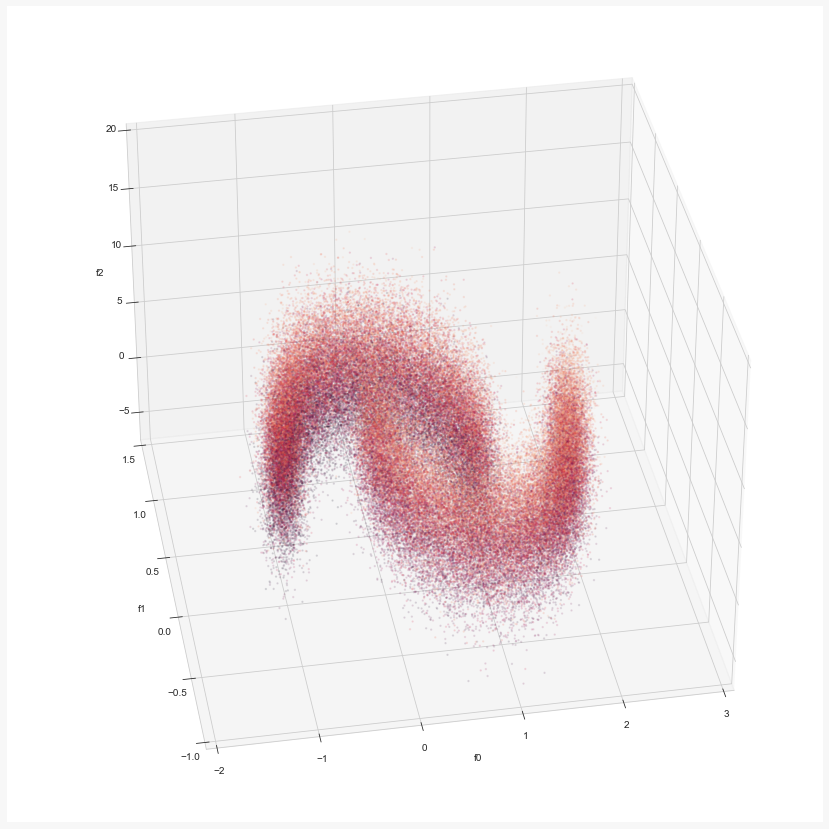

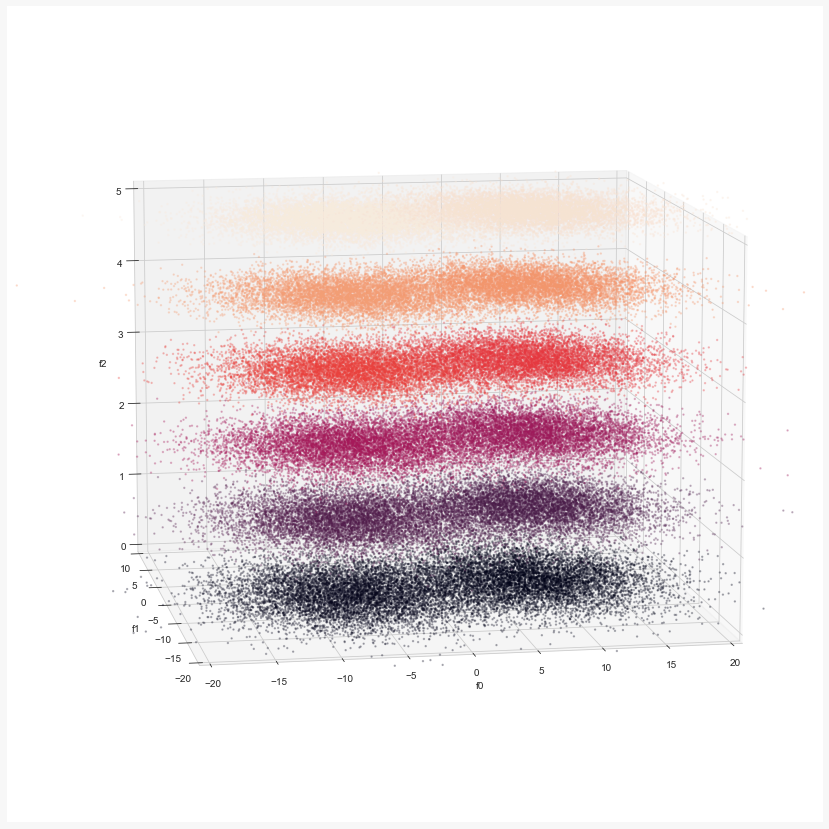

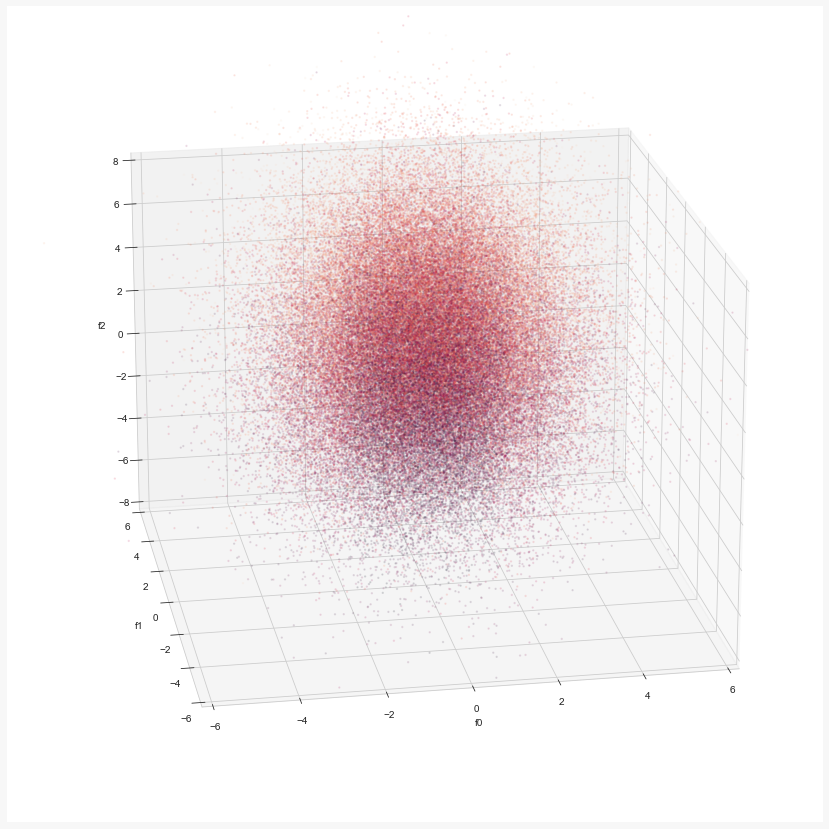

In [10]:
def make_3d(df, alpha, elev, azim, xlim, ylim, zlim):
    '''
    function to make 3d plot
    '''
    fig = plt.figure(figsize=(15, 15))

    ax = fig.add_subplot(projection='3d', azim=azim, elev=elev)
    ax.scatter3D(df['f0'], df['f1'], df['f2']
                 , s=2
                 , alpha=alpha
                 , c=df['product']
              )
    ax.set(xlabel='f0', ylabel='f1', zlabel='f2', xlim=xlim, ylim=ylim, zlim=zlim)
    plt.show()


make_3d(df_0, alpha=0.1, elev=35, azim=-100, xlim=(-2, 3), ylim=(-1, 1.5), zlim=(-7, 20))
make_3d(df_1, alpha=0.25, elev=10, azim=-100, xlim=(-20, 20), ylim=(-20, 10), zlim=(0, 5))
make_3d(df_2, 0.1, 20, -100, xlim=(-6, 6), ylim=(-6, 6), zlim=(-8, 8))

We divide into training and test samples in a ratio of 3:1

In [11]:
def split_df(df):
    '''
    function split df in train and valid, print shapes and return sets
    :param: df: DataFrame
    :return: X_train, X_valid, y_train, y_valid
    '''
    y = df['product']
    X = df.drop(['product', 'id'], axis=1)
    X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.25
                                                          , shuffle=True
                                                          , random_state=12345)
    
    splitted_sets = {'TRAIN':{"X":X_train, 'y':y_train}, 'VALID':{'X':X_valid, 'y':y_valid}}
    sh_df = pd.DataFrame(data = {
        'subset':['TRAIN', 'VALID']
        , 'X_shape':[splitted_sets['TRAIN']['X'].shape, splitted_sets['VALID']['X'].shape]
        , 'y_shape':[splitted_sets['TRAIN']['y'].shape, splitted_sets['VALID']['y'].shape]
        , 'y_mean':[splitted_sets['TRAIN']['y'].mean(), splitted_sets['VALID']['y'].mean()]
    })
    display(sh_df.set_index('subset'))
    return X_train, X_valid, y_train, y_valid

### Conclusions

Data without gaps, and does not require cleaning
The studied features have different scales, which is critical for Linear Regression. We need to scale them.

## Model training and validation

In [12]:
def create_model(X_train, X_valid, y_train, y_valid):
    '''
    Function perform Scaling, create linear Regression model, fit it on train
    :param X_train:
    :param X_valid:
    :param y_train:
    :param y_valid:
    :return : RMSE, R2 score, predictions_valid
    '''
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    model = LinearRegression(n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    predictions_valid = model.predict(X_valid_scaled)
    rmse = mean_squared_error(y_valid, predictions_valid)**0.5
    return rmse, model.score(X_valid_scaled, y_valid), predictions_valid



====   Calculate Region #0   ====

shapes after splitting


X_shape   y_shape  y_mean
subset                              
TRAIN   (75000, 3)  (75000,)  92.640
VALID   (25000, 3)  (25000,)  92.079

Results on validation subset
RMSE = 37.58
R2 = 0.2799
predictions mean and std: 92.59 and 23.18
target mean and std: 92.08 and 44.29

 -----PLOT predict VS target -----


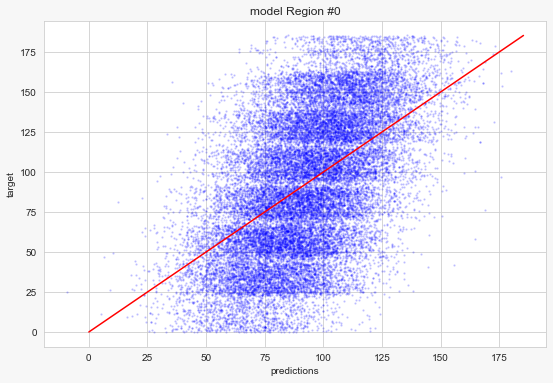




====   Calculate Region #1   ====

shapes after splitting


X_shape   y_shape  y_mean
subset                              
TRAIN   (75000, 3)  (75000,)  68.859
VALID   (25000, 3)  (25000,)  68.723

Results on validation subset
RMSE = 0.89
R2 = 0.9996
predictions mean and std: 68.73 and 46.01
target mean and std: 68.72 and 46.02

 -----PLOT predict VS target -----


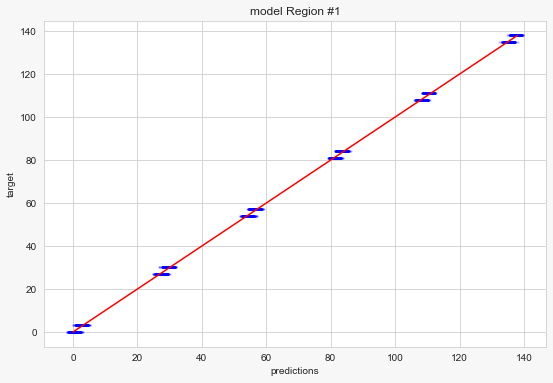




====   Calculate Region #2   ====

shapes after splitting


X_shape   y_shape  y_mean
subset                              
TRAIN   (75000, 3)  (75000,)  95.039
VALID   (25000, 3)  (25000,)  94.884

Results on validation subset
RMSE = 40.03
R2 = 0.2052
predictions mean and std: 94.97 and 19.85
target mean and std: 94.88 and 44.90

 -----PLOT predict VS target -----


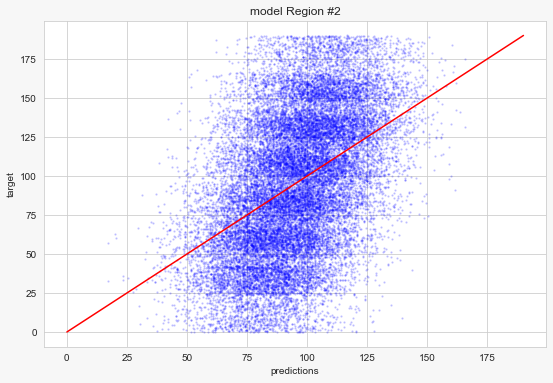

In [13]:
results = []
for name, df in df_all.items():
    print(f'\n\n====   Calculate {name}   ====\n')
    print('shapes after splitting')
    X_train, X_valid, y_train, y_valid = split_df(df)
    rmse, r2, predictions_valid = create_model(X_train, X_valid, y_train, y_valid)
    print('Results on validation subset')
    print(f'RMSE = {rmse:.2f}')
    print(f'R2 = {r2:.4f}')
    print(f'predictions mean and std: {predictions_valid.mean():.2f} and {predictions_valid.std():.2f}')
    print(f'target mean and std: {y_valid.mean():.2f} and {y_valid.std():.2f}')

    print('\n -----PLOT predict VS target -----')
    plt.scatter(predictions_valid, y_valid, s=2, alpha=0.15, c='b')
    plt.plot([0, y_valid.max()], [0, y_valid.max()], c='r')
    plt.xlabel('predictions')
    plt.ylabel('target')
    plt.title('model ' + name)
    plt.show()
    print()
    results.append([pd.Series(predictions_valid), y_valid.reset_index(drop=True)])

### Conclusions
- Models for 0 and 2 regions give a skewed estimate: with low forecasts, the forecast turns out to be overestimated, and with high forecasts, the forecast is underestimated. In general, this should be eliminated, but in our case we need a direct relationship: a larger target corresponds to a larger predict, and this is being done.
- The model of region No. 1 predicts almost perfectly. But the average for this region is 68 versus 92-95 for regions 0 and 2.

## Preparation for profit calculation

In [14]:
SAMPLE_RESEARCH_SIZE = 500
SAMPLE_SELECTED_SIZE = 200
TOTAL_EXPENSES = 10e6  # в тыс руб
PRICE_OF_UNIT = 450
CRITICAL_LOSS_PROBABILITY = 0.025

The volume of raw materials sufficient for the break-even development of a new well

In [15]:
necessary_min_product = TOTAL_EXPENSES / SAMPLE_SELECTED_SIZE / PRICE_OF_UNIT
print(f"Well break-even level: {necessary_min_product:.2f}")

Well break-even level: 111.11


In [16]:

for name, df in df_all.items():
    print(f'Mean product in {name}: {df["product"].mean():.3f}')
    
# print(df_0['product'].mean(), df_1['product'].mean(), df_2['product'].mean(), sep='\n')

Mean product in Region #0: 92.500
Mean product in Region #1: 68.825
Mean product in Region #2: 95.000


### Conclusions

The required volume of raw materials for break-even 111 significantly exceeds the average levels of reserves by region.

## Calculation of profit and risks

In [17]:
# A function for calculating profit from selected wells and model predictions
def calc_profit(predictions, actual):
    '''
    Function for calculating profit from selected wells and model predictions
    :param predictions: predictions of model
    :param actual: actual values
    :return : calculated profit
    '''
    t = pd.DataFrame(zip(predictions, actual), columns = ['predictions', 'actual'])
    s = t.sort_values(by=['predictions'], ascending=False).head(SAMPLE_SELECTED_SIZE)['actual'].sum()
    return round(s * PRICE_OF_UNIT - TOTAL_EXPENSES, 2)

### BOOTSTRAP

In [18]:
state = RandomState(12345)
profits = []
for j in range(3):
    print("\n\nРегион", j)
    profit = []
    predictions = results[j][0]
    y_valid = results[j][1]
    for i in range(1000):
        y_subsample = y_valid.sample(n=SAMPLE_RESEARCH_SIZE, replace=True, random_state=state)
        predictions_subsample = predictions[y_subsample.index]
        profit.append(calc_profit(predictions_subsample, y_subsample))
    profit = pd.Series(profit)
    profits.append(profit)
    print(f"Average profit: {profit.mean():,.2f}")
#     confidence_interval = t.interval(alpha=0.95, df=len(profit) - 1, loc=profit.mean(), scale=profit.sem())
    confidence_interval = [profit.quantile(0.025), profit.quantile(0.975)]
    print(f'Confidence interval: ({confidence_interval[0]:,.2f}, {confidence_interval[1]:,.2f})')
#     loss_prob = len(profit[profit < 0]) / len(profit)
    loss_prob = (profit < 0).mean()
    if loss_prob < CRITICAL_LOSS_PROBABILITY:
        conclusion = "\nSUCCESS !!! the probability of losses is below critical"
    else:
        conclusion = "\nFAILURE !!! the probability of losses is higher than critical"
    print(f"Probability of losses: {loss_prob:.2%} {conclusion}")



Регион 0
Average profit: 396,164.98
Confidence interval: (-111,215.54, 909,766.95)
Probability of losses: 6.90% 
FAILURE !!! the probability of losses is higher than critical


Регион 1
Average profit: 461,155.82
Confidence interval: (78,050.82, 862,952.06)
Probability of losses: 0.70% 
SUCCESS !!! the probability of losses is below critical


Регион 2
Average profit: 392,950.48
Confidence interval: (-112,227.63, 934,562.91)
Probability of losses: 6.50% 
FAILURE !!! the probability of losses is higher than critical


Let's build more histograms of "profitability of 200 wells out of 500 studied" for different areas

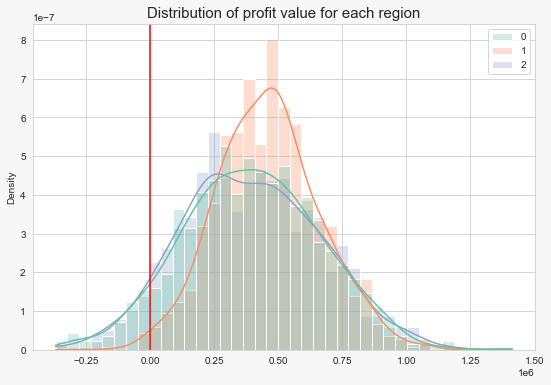

In [19]:
dfr = pd.DataFrame(zip(profits[0], profits[1], profits[2]))
sns.histplot(dfr, kde=True, stat='density', alpha=0.3)
plt.axvline(0, c="r")
plt.title('Distribution of profit value for each region', fontsize=15)
plt.show()

### Conclusion

Only Region 1 meets the criterion "probability of losses below 2.5%"



## Final conclusions

As part of the project, we studied three areas and, using bootstrap technology, estimated the probability of losses at each of the sites when drilling 200 wells out of the 500 studied. As a result, site #1 was chosen as sufficiently reliable and as profitable as possible, the probability of losses on it is less than 1%, and the 95% confidence interval of profit (78,050.82, 862,952.06) with investments of 10,000,000 thousand rubles.